# Exoplanet Course Hands-on Session: Direct Imaging of Beta Pictoris

### Author: Johan Mazoyer

### This jupyter notebook is a support to the direct Imaging hands-on proposed during the PSL exoplanet class directed by Anne-Marie Lagrange and Johan Mazoyer

In [165]:
import copy
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt

import astropy.io.fits as fits
from astropy.time import Time

from orbitize import read_input, driver, system, priors, sampler
import useful_functions_imaging as useful


basedir = "./SPHERE_DC_DATA/"

# Part 1. Reduce the Coronographic Images: Remove remaining speckles

## Loading the data

In [219]:
basedir = "./SPHERE_DC_DATA/"
epoch_dir_name = '2015_02_04/'
#epoch_dir_name = '2016_04_15/'
#epoch_dir_name = '2015_11_29/'
#epoch_dir_name = '2016_01_19/'
#epoch_dir_name = '2018_10_17/'
#epoch_dir_name = '2015_01_29/'
#epoch_dir_name = '2016_11_17/'

data_dir = basedir + epoch_dir_name

centers_images = fits.getdata( data_dir+ "centers_images.fits")
datacube_betapic = fits.getdata(data_dir + "datacube_SPHERE_binned_centered.fits")
parralactic_angles = fits.getdata(data_dir + "parangs_binned.fits")

# for hard imgs
#datacube_betapic=datacube_betapic[-30::2]
#centers_images = centers_images[-30::2]
#parralactic_angles = parralactic_angles[-30::2]

## 1.0 Raw coronagraphic data

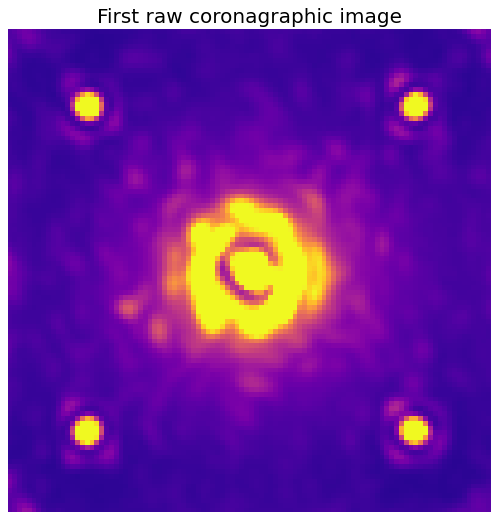

In [220]:
useful.show_psf(useful.quick_crop(datacube_betapic[0], 100),
                vmin=0,
                vmax=800,
                title="First raw coronagraphic image")


In [221]:
useful.explore_slices(useful.quick_crop3d(np.flip(datacube_betapic, axis=(0)),
                                          100),
                      vmin=0,
                      vmax=900,
                      title='Raw Image')

interactive(children=(IntSlider(value=0, description='plane', max=84), Output()), _dom_classes=('widget-intera…

<function useful_functions_imaging.explore_slices.<locals>.display_slice(plane=0)>

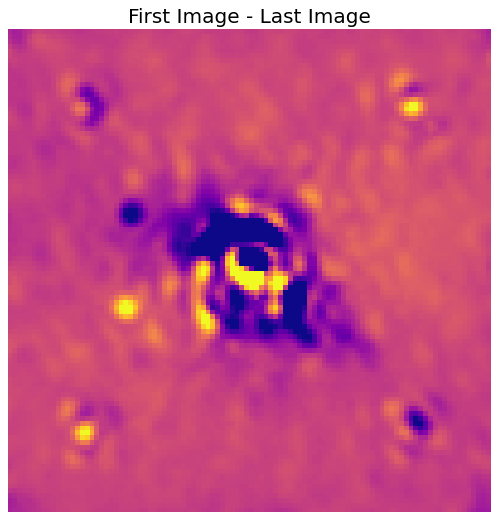

In [222]:
simple_rotate = datacube_betapic[0] - datacube_betapic[-1]
fits.writeto( data_dir + "reduc_simple_rotate.fits",simple_rotate, overwrite=True)

useful.show_psf(useful.quick_crop(simple_rotate,100), vmin = -200, vmax = 200, title = "First Image - Last Image")


## 1.2. Classical Angular Differential Imaging (cADI)

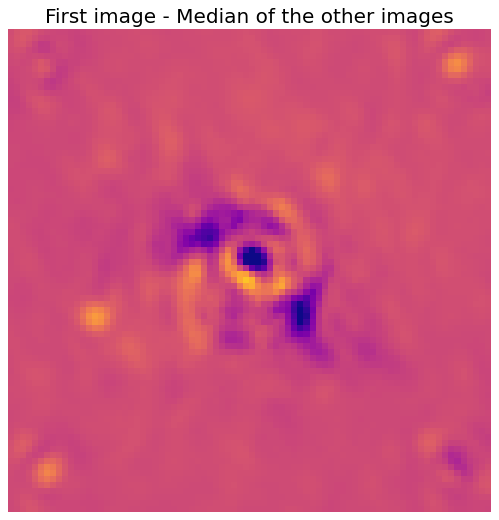

In [223]:
first_image_minus_median_rest = datacube_betapic[0] - np.nanmedian(
    datacube_betapic[1:], axis=0)
useful.show_psf(useful.quick_crop(first_image_minus_median_rest, 80),
                vmin=-500,
                vmax=500,
                title="First image - Median of the other images")


In [224]:
datacube_SPHERE_classical_adi_sub = useful.subtract_classical_adi_median(
    datacube_betapic, data_dir)
useful.explore_slices(useful.quick_crop3d(
    np.flip(datacube_SPHERE_classical_adi_sub, axis=(0)), 180),
                      vmin=-600,
                      vmax=600,
                      title='Median subtracted Images')


Start cADI
End cADI


interactive(children=(IntSlider(value=0, description='plane', max=84), Output()), _dom_classes=('widget-intera…

<function useful_functions_imaging.explore_slices.<locals>.display_slice(plane=0)>

### We can "derotate": Put all the images with the North on top of the images. The planet will always be at the same place. We then average the cube

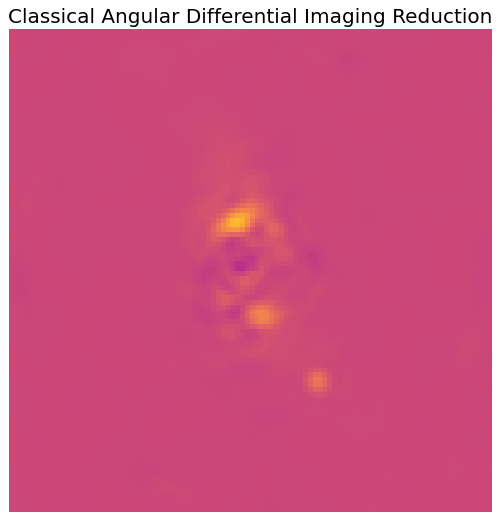

In [225]:

reduc_classical_adi = useful.derotate_and_mean_classical_adi(
    datacube_SPHERE_classical_adi_sub, parralactic_angles, data_dir)
useful.show_psf(useful.quick_crop(reduc_classical_adi, 100),
                vmin=-700,
                vmax=700,
                title="Classical Angular Differential Imaging Reduction")


## 1.3. Principal component analysis (PCA)

In [226]:
PCA_components = np.arange(20)

reduc_pca = useful.simple_pca_already_centered(datacube_betapic, 
                                               centers_images, 
                                               parralactic_angles,
                                               PCA_components,
                                               data_dir)



Total number of tasks for KLIP processing is 1
Begin processing of wv 1.0 with index 0
Aligning and scaling imgs
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Closing threadpool
end PCA


In [227]:
useful.explore_slices(useful.quick_crop3d(reduc_pca, 100),
                      vmin=-500,
                      vmax=500,
                      title='Number of PCA modes subtracted:')


interactive(children=(IntSlider(value=0, description='plane', max=19), Output()), _dom_classes=('widget-intera…

<function useful_functions_imaging.explore_slices.<locals>.display_slice(plane=0)>

# Part 2. Determining the physical position of Beta-Pictoris b

In [228]:
star_distance = 19.45 # Distance of the Beta Pictoris star in parsecs. 
# 1 parsec corresponds to 3.26 light year or 3.1x10^13 km
plate_scale = 12.25  # Plate scale of the SPHERE instrument in miliarcsecond / pixel. 
# 1 milliarcsecond is 1/(3600*1000) degrees on the sky

## 2.1 Calculate the distance star - planet in each of the epochs

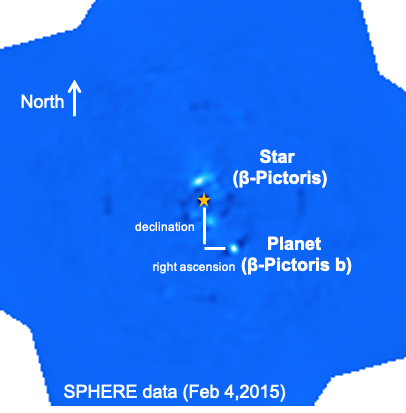

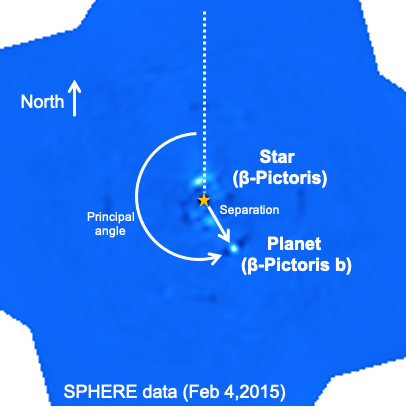

In [231]:
position_star_pixel = [100,100]


# We simply take the brightness pixel in the image to assess the position of the planet
position_planet_pixel = [115, 77] 
# replace by the value in pixel found with DS9
# careful DS9 starts the first pixel in [1,1] and python starts the first pixel
# at [0,0]

std_error_in_pos = 2. #pixels. 
# Because of the method we're using to find the position (brightest pixel), 
# we're very unprecise on the real position of the planet. 



### Other methods to find the position include fitting a gaussian to the planet diffraction pattern. 
### Ultra precise astrometry of the planet in the image is an active research field and actual precision is on the order of a tenth of a pixel (precision of a milliarcsecond).

In [232]:

std_error_in_pos_mas = plate_scale * std_error_in_pos
relative_RA = -plate_scale * (position_planet_pixel[0] -
                                       position_star_pixel[0])
relative_dec = plate_scale * (position_planet_pixel[1] -
                                        position_star_pixel[1])


separation = useful.separation_planet(relative_RA,relative_dec)
error_separation = np.std(
    useful.separation_planet(
        np.random.normal(relative_dec,
                         std_error_in_pos_mas,
                         size=5000),
        np.random.normal(relative_RA,
                         std_error_in_pos_mas,
                         size=5000)))


PA = useful.PA_planet(relative_dec, relative_RA)
error_PA = np.std(
    useful.PA_planet(
        np.random.normal(relative_dec,
                         std_error_in_pos_mas,
                         size=5000),
        np.random.normal(relative_RA,
                         std_error_in_pos_mas,
                         size=5000)))

print("Right ascension: {:.3f} +/- {:.3f}  milliarcseconds".format(
    relative_RA, std_error_in_pos_mas))
print("Declination: {:.3f} +/- {:.3f}  milliarcseconds".format(
    relative_dec, std_error_in_pos_mas))
print("Separation: {:.3f} +/- {:.3f}  milliarcseconds".format(
    separation, error_separation))
print("PA: {:.3f} +/- {:.3f}  degrees".format(
    (360+PA)%360 , error_PA))
print("")
print("")


Right ascension: -183.750 +/- 24.500  milliarcseconds
Declination: -281.750 +/- 24.500  milliarcseconds
Separation: 336.373 +/- 24.732  milliarcseconds
PA: 213.111 +/- 4.156  degrees




## 2.2 Compare the results to Lagrange et al. (2019) paper

# Part 3. Orbit Fitting

In [233]:
# convert our epoch dates to MJD (Modified Julian Date).
epoch_dates = ['2014-12-08','2015-02-05', '2015-10-01','2015-11-30','2015-12-26',
               '2016-01-20', '2016-03-26','2016-04-16','2016-09-16','2016-10-14','2016-11-18',
               '2018-09-17']

epochs_mjd = Time(epoch_dates).mjd
print("Epoch dates in Modified Julian Date (MJD): ", epochs_mjd)

Epoch dates in Modified Julian Date (MJD):  [56999. 57058. 57296. 57356. 57382. 57407. 57473. 57494. 57647. 57675.
 57710. 58378.]


In [234]:
# we write this into a cvs file to be able to launch Orbitize package ! 
rows = []
# rows.append(['epoch','object','raoff','raoff_err','decoff','decoff_err',
#                        'radec_corr','sep','sep_err','pa','pa_err','rv','rv_err'])
# rows.append([57057,0,'','','','','',336.4, 12.2, 213.1, 2.1,'',''])
# rows.append([57493,0,'','','','','',193.7, 12.5, 214.7, 3.6,'',''])
# rows.append([58408,0,'','','','','',153.5, 12.5, 28.6 , 4.6,'',''])

rows.append(['epoch','object','raoff','raoff_err','decoff','decoff_err',
                 'radec_corr','sep','sep_err','pa','pa_err','rv','rv_err'])
rows.append(['56999.0','1','','','','','','350.51','3.2','212.6','0.7','',''])
rows.append(['57058.0','1','','','','','','332.42','1.7','212.6','0.4','',''])
rows.append(['57296.0','1','','','','','','262.02','1.8','213.02','0.5','',''])
rows.append(['57356.0','1','','','','','','242.05','2.5','213.3','0.7','',''])
rows.append(['57382.0','1','','','','','','234.84','1.8','213.79','0.5','',''])
rows.append(['57407.0','1','','','','','','227.23','1.6','213.15','0.5','',''])
rows.append(['57473.0','1','','','','','','203.66','1.4','213.90','0.5','',''])
rows.append(['57494.0','1','','','','','','197.49','2.4','213.88','0.8','',''])
rows.append(['57647.0','1','','','','','','142.36','2.3','214.62','1.1','',''])
rows.append(['57675.0','1','','','','','','134.50','2.5','215.5','1.2','',''])
rows.append(['57710.0','1','','','','','','127.12','6.4','215.8','3.4','',''])
rows.append(['58408.0','1','','','','','','140.46','3.1','29.71','1.7','',''])


filename = basedir + 'betapic_position.csv'
useful.write_orbit_in_cvs(filename, rows)

data_table = read_input.read_file(filename)
print(data_table)


 epoch  object quant1 quant1_err ... quant12_corr quant_type instrument
------- ------ ------ ---------- ... ------------ ---------- ----------
56999.0      1 350.51        3.2 ...          nan      seppa      defsp
57058.0      1 332.42        1.7 ...          nan      seppa      defsp
57296.0      1 262.02        1.8 ...          nan      seppa      defsp
57356.0      1 242.05        2.5 ...          nan      seppa      defsp
57382.0      1 234.84        1.8 ...          nan      seppa      defsp
57407.0      1 227.23        1.6 ...          nan      seppa      defsp
57473.0      1 203.66        1.4 ...          nan      seppa      defsp
57494.0      1 197.49        2.4 ...          nan      seppa      defsp
57647.0      1 142.36        2.3 ...          nan      seppa      defsp
57675.0      1  134.5        2.5 ...          nan      seppa      defsp
57710.0      1 127.12        6.4 ...          nan      seppa      defsp
58408.0      1 140.46        3.1 ...          nan      seppa    

In [238]:
# Beta Pictoris system parameters
num_planets = 1
total_mass = 1.75 # Mass of beta pic star [Msol]
plx = 51.44 # Parallaxe of beta pic star [milliarcesonds] 
mass_err = 0.05 # error on the mass [Msol]
plx_err = 0.12 # error on the Parallaxe [milliarcesonds]

In [239]:
# MCMC parameters (reduce to go faster)
# number of temperatures & walkers for MCMC
num_temps = 2
num_walkers = 1000
# number of steps to take
total_orbits = 100000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 50 # steps to burn in per walker
thin = 1 

In [240]:
# Initialize the MCMC
sys = system.System(
    num_planets, data_table, total_mass,
plx, mass_err=mass_err, plx_err=plx_err)

# adding a strong prior on inclination and eccentricity
lab = sys.param_idx

# inc_mu = np.radians(89.1)
# inc_sigma = np.radians(0.1)
# sys.sys_priors[lab['inc1']] = priors.GaussianPrior(inc_mu, inc_sigma)

inc_min = np.radians(88.0)
inc_max = np.radians(89.9)
sys.sys_priors[lab['inc1']] = priors.UniformPrior(inc_min, inc_max)


ecc_min = 0.0001
ecc_max = 0.05
sys.sys_priors[lab['ecc1']] = priors.UniformPrior(ecc_min, ecc_max)

# we also add a prior on the position of the nodes to avoid dual solution
pan_min = np.radians(180)
pan_max = np.radians(359)
sys.sys_priors[lab['pan1']] = priors.UniformPrior(pan_min, pan_max)

# print(sys.labels)
# print(sys.sys_priors)
# print(sys.param_idx)

# We initialize the MCMC at the positions given by Lagrange et al. 2019
sampler_betapic = sampler.MCMC(sys, num_temps, num_walkers)

theta_init = [9,0.02,np.radians(89.1),np.radians(350), np.radians(212),0.3, plx, total_mass]
initial_pos = useful.initialize_walkers(theta_init, num_temps, num_walkers)
sampler_betapic.curr_pos = initial_pos
    
# print(sampler_betapic.curr_pos.shape)
# print(sampler_betapic.curr_pos[0,0,:])


In [241]:
# run the MCMC
_ = sampler_betapic.run_sampler(total_orbits, burn_steps, thin)

TypeError: __init__() got an unexpected keyword argument 'ntemps'

In [ ]:
# plot the results
myResults_betapic = sampler_betapic.results
orbit_figure = myResults_betapic.plot_orbits(
    start_mjd=data_table['epoch'][0] ,
    num_orbits_to_plot=25)# minimum MJD for colorbar (choose first data epoch)
orbit_figure.savefig(basedir + 'orbitebetapic.pdf')

# Creates a corner plot and returns Figure object
corner_plot_fig = myResults_betapic.plot_corner(
        param_list=['sma1','ecc1','inc1','aop1','pan1','tau1'], 
        range=(0.95,0.95,0.95,0.95,0.95,0.95)) 
corner_plot_fig.savefig(basedir + 'orbitebetapic_corner_plot.pdf')




In [ ]:

my_posteriors_betapic = myResults_betapic.post
lab = sys.param_idx

# we use the posteriors in semi major axis and total mass to obtain the posterior in period
# using the third kepler law
period_posterior = useful.third_kepler_law(
    my_posteriors_betapic[:, lab['sma1']],
    my_posteriors_betapic[:, lab['mtot']])

plt.figure()
periods = period_posterior[np.where(
    period_posterior < 50)]
plt.hist(periods)
plt.xlabel('Period (years)')
plt.ylabel('number of orbits')

print("Period: {:.3f} +/- {:.3f}  years".format(np.nanmean(periods),
                                                np.nanstd(periods)))

# Adding the final point ! 


### In Lagrange et al. 2009, the planet was first detected in November 2003 data, 
###  They measured Separation = 413 +/-22 milliarseconds and PA = 34.42 +/-3.52 degrees

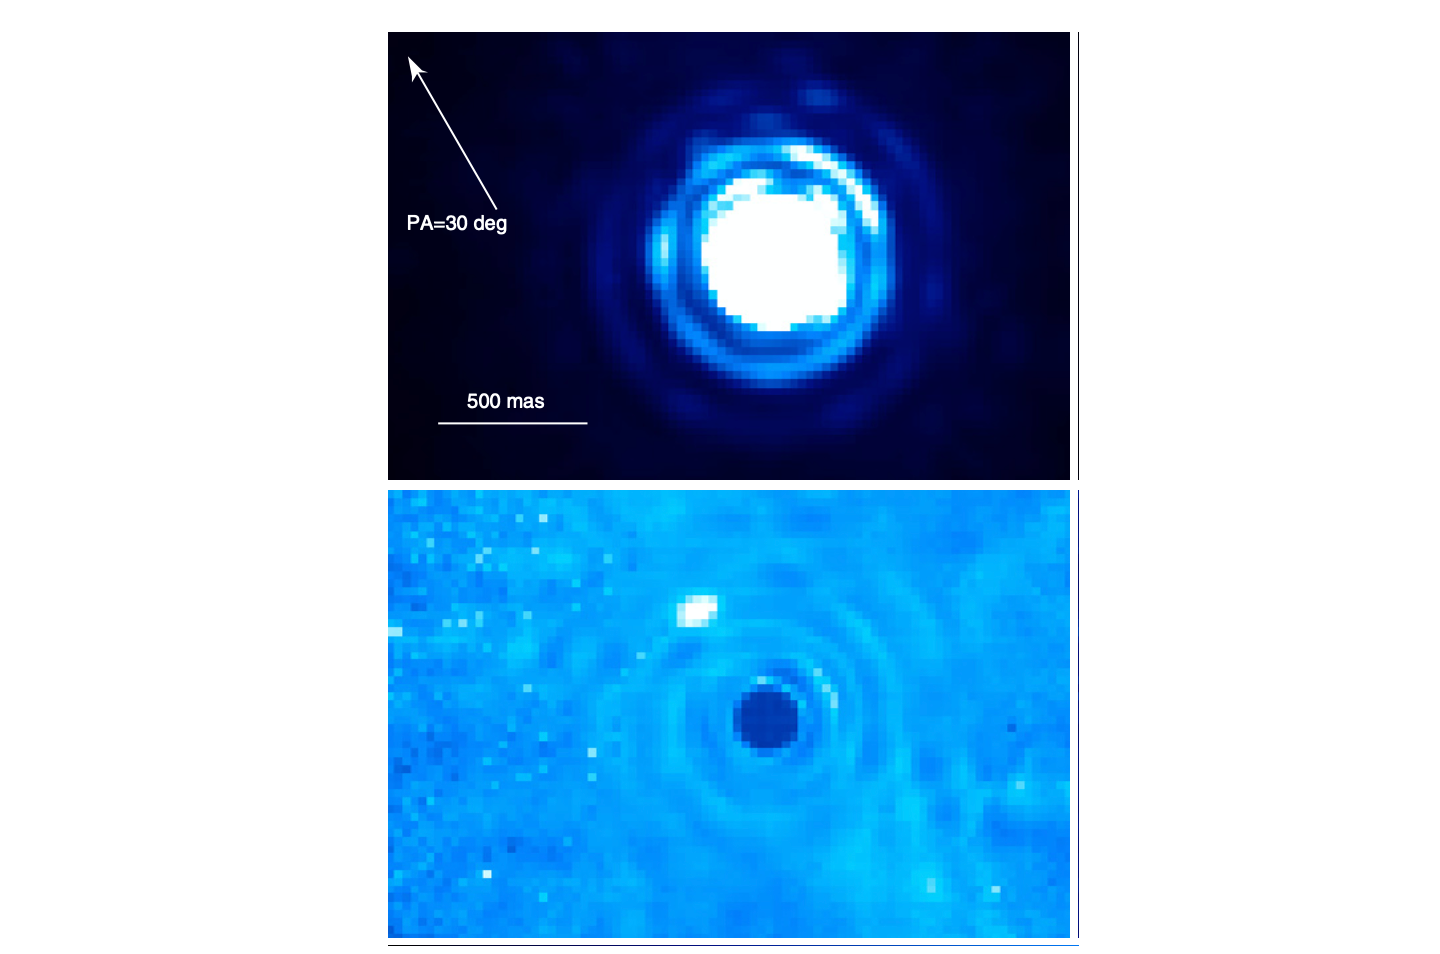

In [242]:
first_detection_date = ['2003-11-10'] 
epochs_mjd = Time(first_detection_date).mjd
print("First_detection_date Modified Julian Date (MJD): ", epochs_mjd)

First_detection_date Modified Julian Date (MJD):  [52953.]


In [243]:
new_rows = copy.copy(rows)
new_rows.insert(1,['52953.0','1','','','','','','413','22','34.42','3.52','',''])


filename = basedir + 'betapic_position_with2003.csv'
useful.write_orbit_in_cvs(filename, new_rows)

data_table = read_input.read_file(filename)
print(data_table)


 epoch  object quant1 quant1_err ... quant12_corr quant_type instrument
------- ------ ------ ---------- ... ------------ ---------- ----------
52953.0      1  413.0       22.0 ...          nan      seppa      defsp
56999.0      1 350.51        3.2 ...          nan      seppa      defsp
57058.0      1 332.42        1.7 ...          nan      seppa      defsp
57296.0      1 262.02        1.8 ...          nan      seppa      defsp
57356.0      1 242.05        2.5 ...          nan      seppa      defsp
57382.0      1 234.84        1.8 ...          nan      seppa      defsp
57407.0      1 227.23        1.6 ...          nan      seppa      defsp
57473.0      1 203.66        1.4 ...          nan      seppa      defsp
57494.0      1 197.49        2.4 ...          nan      seppa      defsp
57647.0      1 142.36        2.3 ...          nan      seppa      defsp
57675.0      1  134.5        2.5 ...          nan      seppa      defsp
57710.0      1 127.12        6.4 ...          nan      seppa    

In [244]:
# Re-nitialize the MCMC
sys_with2003 = system.System(
                        num_planets, data_table, total_mass,
                        plx, mass_err=mass_err, plx_err=plx_err)

# adding a strong prior on inclination and eccentricity
lab = sys_with2003.param_idx

inc_min = np.radians(88.5)
inc_max = np.radians(89.8)
sys_with2003.sys_priors[lab['inc1']] = priors.UniformPrior(inc_min, inc_max)


ecc_min = 0.0001
ecc_max = 0.05
sys_with2003.sys_priors[lab['ecc1']] = priors.UniformPrior(ecc_min, ecc_max)

# we also add a prior on the position of the nodes to avoid dual solution
pan_min = np.radians(180.1)
pan_max = np.radians(359.9)
sys_with2003.sys_priors[lab['pan1']] = priors.UniformPrior(pan_min, pan_max)


# We initialize the MCMC at the positions given by Lagrange et al. 2019
sampler_betapic_with2003 = sampler.MCMC(sys_with2003, num_temps, num_walkers)

theta_init = [9,0.02,np.radians(89.1),np.radians(350), np.radians(212),0.3, plx, total_mass]
initial_pos = useful.initialize_walkers(theta_init, num_temps, num_walkers)
sampler_betapic_with2003.curr_pos = initial_pos
    
# print(sampler_betapic.curr_pos.shape)
# print(sampler_betapic.curr_pos[0,0,:])




In [245]:
# run the MCMC
_ = sampler_betapic_with2003.run_sampler(total_orbits, burn_steps, thin)

TypeError: __init__() got an unexpected keyword argument 'ntemps'

In [246]:
# plot the results
myResults_betapic_with2003 = sampler_betapic_with2003.results
orbit_figure = myResults_betapic_with2003.plot_orbits(
    start_mjd=data_table['epoch'][0] ,
    num_orbits_to_plot=25)# minimum MJD for colorbar (choose first data epoch)
orbit_figure.savefig(basedir + 'orbitebetapic_with2003.pdf')

# Creates a corner plot and returns Figure object
corner_plot_fig = myResults_betapic_with2003.plot_corner(
        param_list=['sma1','ecc1','inc1','aop1','pan1','tau1'], 
        range=(0.95,0.95,0.95,0.95,0.95,0.95)) 
corner_plot_fig.savefig(basedir + 'orbitebetapic_corner_plot_with2003.pdf')

TypeError: 'NoneType' object is not subscriptable

In [247]:
my_posteriors_betapic_with2003 = myResults_betapic_with2003.post
lab = sys.param_idx

# we use the posteriors in semi major axis and total mass to obtain the posterior in period
# using the third kepler law
period_posterior_with2003 = useful.third_kepler_law(
    my_posteriors_betapic_with2003[:, lab['sma1']],
    my_posteriors_betapic_with2003[:, lab['mtot']])

plt.figure()
periods = period_posterior_with2003[np.where(
    period_posterior_with2003 < 50)]
plt.hist(periods)
plt.xlabel('Period (years)')
plt.ylabel('number of orbits')

print("Period: {:.3f} +/- {:.3f}  years".format(np.nanmean(periods),
                                                np.nanstd(periods)))

TypeError: 'NoneType' object is not subscriptable

## Acknowledgements

This notebook makes great use of the [`pyklip`](https://pyklip.readthedocs.io/en/latest/) and [`orbitize!`](https://orbitize.readthedocs.io/en/latest/index.html) packages and of the data of the VLT/SPHERE and VLT/NaCO instrument. 
Orbital data was extracted from [`Lagrange et al. (2009)`](http://adsabs.harvard.edu/abs/2009A%26A...493L..21L), [`Chauvin et al. (2012)`](https://ui.adsabs.harvard.edu/abs/2012A%26A...542A..41C), [`Lagrange et al. (2019)`](http://adsabs.harvard.edu/abs/2019A%26A...621L...8L). 

This work has made use of the the [`SPHERE Data Centre`](https://sphere.osug.fr/spip.php?rubrique35&lang=en), jointly operated by OSUG/IPAG (Grenoble), PYTHEAS/LAM/CESAM (Marseille), OCA/Lagrange (Nice), Observatoire de Paris/LESIA, and Observatoire de Lyon. Many thanks to Phillipe Delorme who provided SPHERE image data.

This notebook was developed by Johan Mazoyer (LESIA / PSL - Observatoire de Paris / CNRS) and is under [`Beerware license`](https://en.wikipedia.org/wiki/Beerware).